# Machine Learning LAB 3: LINEAR REGRESSION

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:
idx    | frame size (B) |  time (s)
0      | 38424          |  0.0
1      | 39801          |  0.01944
...

The game was run at 60 frames per second, with a target rate of 30 Mb/s. The task is then to predict the size of the next frame, given the past N frames. This was explored in another paper:

Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')

## Prepare the data and create training and test sets

In this case, we are learning a time series: let us consider a memory of 2 samples, i.e., use X[n-1] and X[n-2] to predict X[n].

In [2]:
# Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size

# Compute the splits and prepare the columns
m_training = int(0.75*norm_data.shape[0])

X_training = np.ones([m_training - 2, 3])
X_training[:,1] = norm_data[: m_training - 2]
X_training[:,2] = norm_data[1 : m_training - 1]
Y_training = norm_data[2 : m_training]


X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print(np.shape(X_training), np.shape(Y_training), np.shape(X_test), np.shape(Y_test))

(25878, 3) (25878,) (8625, 3) (8625,)


## Least Squares linear regression

Train and evaluate the LS regressor on the data

In [3]:
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    ## TODO: Run the LS algorithm without regularization

    A = np.dot(np.transpose(X_matrix), X_matrix)
    b = np.dot(np.transpose(X_matrix), labels)

    return np.dot(np.linalg.inv(A), b)

def evaluate_model(x, y, coeff):
    ## TODO: Return the average MSE for the set over which we evaluate

    return np.sum((np.dot(x, coeff) - y)**2)/len(y)

In [4]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('Root MSE:', np.sqrt(mse) * avg_size)

Model coefficients: [0.36986742 0.20348677 0.42565451]
Root MSE: 7712.354721539114


---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$

In [36]:
# Least squares solution
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray) -> None:
    ## TODO: Run the LS algorithm with regularization
    A = np.dot(np.transpose(X_matrix), X_matrix)
    b = np.dot(np.transpose(X_matrix), labels)
    lambda_mat = lambda_par*np.eye(np.shape(A)[0])

    return (np.dot(np.linalg.inv(A + lambda_mat), b))


import time
def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> None:
    ## TODO: Perform K-fold cross-validation

    perm = np.random.permutation(len(X_training))
    X_training = X_training[perm]
    Y_training = Y_training[perm]

    results = []
    for l in lambda_vec:

        fracData = int(np.floor(len(X_training)/K))
        Eval = []

        for k in range(K):

            idx = np.arange(np.shape(X_training)[0])

            valIDX = np.arange(fracData) + k*fracData
            s = time.time()
            trainIDX = np.setdiff1d(np.arange(len(X_training)), valIDX)
            e = time.time()
            #print(e - s)

            xTrain, yTrain = X_training[trainIDX], Y_training[trainIDX]
            xVal, yVal = X_training[valIDX], Y_training[valIDX]


            coeff = regularized_least_squares(xTrain, yTrain, l)
            evaluate = evaluate_model(xVal, yVal, coeff)

            Eval.append(evaluate)
        
        results.append(np.mean(Eval))

    best_model = lambda_vec[np.argmin(results)]

    return best_model, 0, 0, results    





4 [0.021429928501961914, 0.02142989648743808, 0.021429873721839264, 0.021429860036083853, 0.021429855264379606, 0.021429859244152694, 0.0214298718159782, 0.021429892823512403, 0.02142992211342689, 0.02142995953534388, 0.02143000494177348, 0.021430058188052138, 0.021430119132282887, 0.02143018763527645, 0.021430263560494538, 0.02143034677399379, 0.021430437144371376, 0.02143053454271178, 0.021430638842534953, 0.02143074991974549, 0.021430867652583084]


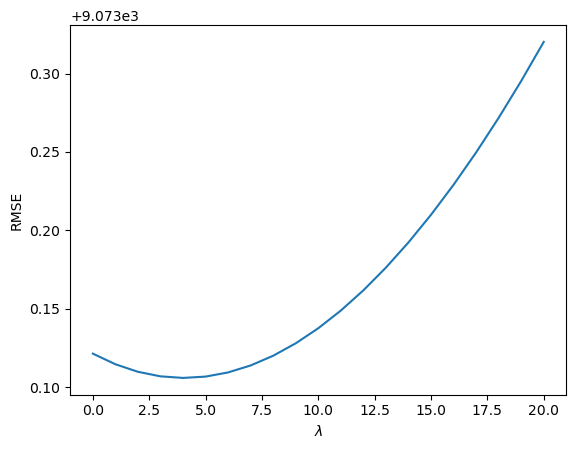

In [37]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = range(21)

best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par, K)
print(best_model, results)
plt.plot(lambda_par, np.sqrt(results) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


In [8]:
# Plot the results for the regularized models on the test set
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])

plt.plot(lambda_par, np.sqrt(test_scores) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


NameError: name 'models' is not defined

### EXTRA

Can you figure out the best amount of memory to use?
